# Packages and functions

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
import itertools
from collections import defaultdict
import time
from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torchvision import datasets, transforms, utils
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen
import snntorch.spikeplot as splt
import math

torch.manual_seed(42)
np.random.seed(42)

#print(torch.cuda.is_available())

In [2]:
#data_path='/data/mnist'
data_path = '\\Users\\liamh\\OneDrive - University of Strathclyde\\University'
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Training Parameters
batch_size=128

# Network Architecture
num_hidden = 350
num_outputs = 10
dropout = 0.25

loss_fn = nn.NLLLoss()  # Negative log-likelihood loss function
log_softmax_fn = nn.LogSoftmax(dim=-1) # Softmax activation for the output layer. -1 in 'dim' indicates last dimension (the labels.)

# Functions and parameters used across different model types

In [3]:
def load_in_data(res, ratio = 1):
    transform = transforms.Compose([
        transforms.Resize((res, res)), #Resize images to 28*28
        transforms.Grayscale(), # Make sure image is grayscale
        transforms.ToTensor()]) # change each image array to a tensor which automatically scales inputs to [0,1]

    mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # Download training set and apply transformations. 
    mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform) # same for test set

    train_len = int(len(mnist_train)/ratio)
    dummy_len = len(mnist_train) - train_len
    train_dataset, _ = random_split(mnist_train, (train_len, dummy_len), generator=torch.Generator().manual_seed(42))
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # Load the data into the DataLoader so it's passed through the model, shuffled in batches. 
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)
    
    return train_loader, test_loader

def output_formula(input_size, filter_size, padding, stride):
    formula = math.floor(((((input_size - filter_size + 2*padding)/stride) + 1)))
    
    return formula 

def all_output_sizes(res, conv_filter = 3, conv_padding = 1, conv_stride = 1, mp_filter = 3, mp_padding = 0, mp_stride = 2):
    
    conv1 = output_formula(res, conv_filter, conv_padding, conv_stride)   # Output size from applying conv1 to input 
    mp1 = output_formula(conv1, mp_filter, mp_padding, mp_stride)         # Output size from applying max pooling 1 to conv1 
    
    conv2 = output_formula(mp1, conv_filter, conv_padding, conv_stride)   # Output size from applying conv2 to max pooling 1
    conv3 = output_formula(conv2, conv_filter, conv_padding, conv_stride) # Output size from applying conv3 to conv 2
    mp2 = output_formula(conv3, mp_filter, mp_padding, mp_stride)         # Output size from applying max pooling 2 to conv3
    
    conv4 = output_formula(mp2, conv_filter, conv_padding, conv_stride)   # Output size from applying conv 4 to max pooling 2
    conv5 = output_formula(conv4, conv_filter, conv_padding, conv_stride) # Output size from applying conv5 to conv 4
    mp3 = output_formula(conv5, mp_filter, mp_padding, mp_stride)         # Output size from applying max pooling 3 to conv 5
    
    outputs_I_need = [mp1, conv2, mp2, conv4, mp3]
    
    return outputs_I_need

def plot_training_history(history, res, loss_upper = 1.05, acc_lower = -0.05, acc_higher = 105):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    
    ax1.plot(history['avg_train_loss'], label='train loss',marker = 'o')
    ax1.plot(history['avg_valid_loss'], label='validation loss',marker = 'o')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, loss_upper])
    ax1.legend()
    ax1.set_ylabel('Loss',fontsize = 16)
    ax1.set_xlabel('Epoch',fontsize = 16)
    
    ax2.plot(history['train_accuracy'], label='train accuracy',marker = 'o')
    ax2.plot(history['valid_accuracy'], label='validation accuracy',marker = 'o')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([acc_lower, acc_higher])

    ax2.legend()

    ax2.set_ylabel('Accuracy',fontsize = 16)
    ax2.yaxis.set_major_formatter(PercentFormatter(100))
    ax2.set_xlabel('Epoch',fontsize = 16)
    fig.suptitle(f'Training history ({res}*{res})',fontsize = 20)
    plt.show()

def store_best_results(history):
    # Want to take the last entry from each output(best results) and store them all in a Dataframe
    placeholder = []
    placeholder.append(history['avg_train_loss'][-1])
    placeholder.append(history['train_accuracy'][-1])
    placeholder.append(history['avg_valid_loss'][-1])
    placeholder.append(history['valid_accuracy'][-1])
    
    return placeholder

def put_results_in_df(output):
    df = pd.DataFrame()
    df['avg_train_loss'] = output['avg_train_loss']
    df['train_accuracy'] = output['train_accuracy']
    df['avg_valid_loss'] = output['avg_valid_loss']
    df['valid_accuracy'] = output['valid_accuracy']
    
    return df

In [4]:
# Define a different network
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = conv_kernel_size, padding = conv_padding_size), # Do I change channels to a variable incase I end up with RGB images? ## Padding = 0 as all information is at the centre of image (may change if lower resolution)
            nn.MaxPool2d(kernel_size = mp_kernel_size, stride = mp_stride_length),
            nn.ReLU(),
            
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = conv_kernel_size, padding = conv_padding_size),  #'same'
            nn.ReLU(), 
            
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = conv_kernel_size, padding = conv_padding_size), 
            nn.MaxPool2d(kernel_size = mp_kernel_size, stride = mp_stride_length), 
            nn.ReLU(),
            
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = conv_kernel_size, padding = conv_padding_size),
            nn.ReLU(), 
            
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = conv_kernel_size, padding = conv_padding_size),
            nn.MaxPool2d(kernel_size = mp_kernel_size, stride = mp_stride_length), 
            nn.ReLU())
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(256 * output_sizes[-1] * output_sizes[-1], num_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(num_hidden,num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_outputs)
        )
        
    def forward(self, x):
        x = self.convolutions(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        
        return(F.log_softmax(x,dim = 1))

In [5]:
def train_model(train_loader, valid_loader, model, epochs ,device = device, verbose = True):
    print('Training Starting')
    start_time = time.time()
    history = defaultdict(list)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999)) # Just an Adam Optimiser

    
    # Training variables
    train_size = len(train_loader.dataset)
    train_num_batches = len(train_loader)
    
    # validation variables
    valid_size = len(valid_loader.dataset)
    num_batches = len(valid_loader)
    
    
    for t in range(epochs):
        correct = 0
        avg_valid_loss, valid_correct = 0, 0
        model.train()
        for batch, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            # Compute prediction and loss
            
            pred = model(X)
            
            loss = loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # Store loss history for future plotting

            # Backpropagation
            loss.backward()
            optimizer.step()


        history['avg_train_loss'].append(loss.item())
        avg_train_loss = loss / train_num_batches
        accuracy = correct / train_size * 100           
        history['train_accuracy'].append(accuracy)
        
        if verbose == True: 
            print(f"Epoch {t+1} of {epochs}")
            print('-' * 15)
            print(f"Training Results, Epoch {t+1}:\n Accuracy: {(accuracy):>0.1f}%, Avg loss: {avg_train_loss.item():>8f} \n")

              ###################### VALIDATION LOOP ##############################
        model.eval()
        with torch.no_grad():
            for valid_X, valid_y in valid_loader:
                valid_X = valid_X.to(device)
                valid_y = valid_y.to(device)

                valid_pred = model(valid_X)
                valid_loss = loss_fn(valid_pred, valid_y).item()
                avg_valid_loss += loss_fn(valid_pred, valid_y).item()
                valid_correct += (valid_pred.argmax(1) == valid_y).type(torch.float).sum().item()

        avg_valid_loss /= num_batches
        valid_accuracy = valid_correct / valid_size * 100

        history['avg_valid_loss'].append(avg_valid_loss)
        history['valid_accuracy'].append(valid_accuracy)
        
        if verbose == True: 
            print(f"Validation Results, Epoch {t+1}: \n Accuracy: {(valid_accuracy):>0.1f}%, Avg loss: {avg_valid_loss:>8f} \n")


    print("Done!")
    print(f"Final Train Accuracy: {(accuracy):>0.1f}%, and Avg loss: {avg_train_loss.item():>8f} \n")
    print(f"Final Validation Accuracy: {(valid_accuracy):>0.1f}%, and Avg loss: {avg_valid_loss:>8f} \n")
    current_time = time.time()
    total = current_time - start_time
    print(f'Training time: {round(total/60,2)} minutes')
    return history

def get_ann_results(resolution, epochs = 20, ratio = 1, verbose = True):
    #output_sizes = all_output_sizes(resolution, conv_kernel_size, conv_padding_size, conv_stride_length, mp_kernel_size, mp_padding_size, mp_stride_length)
    train, valid = load_in_data(resolution, ratio = ratio)
    model = CNN().to(device)

    output = train_model(train,valid,model,epochs, verbose = verbose)
    
    return output

# Training models

In [6]:
conv_kernel_size = 3
conv_stride_length = 1 
conv_padding_size = 1
mp_kernel_size = 2 
mp_stride_length = 2 
mp_padding_size = 0

## 56x56

In [7]:
output_sizes = all_output_sizes(56, conv_kernel_size, conv_padding_size, conv_stride_length, mp_kernel_size, mp_padding_size, mp_stride_length)

In [8]:
batch_size = 128
output_56_r1 = get_ann_results(resolution = 56, ratio = 1, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.8%, and Avg loss: 0.000000 

Final Validation Accuracy: 99.3%, and Avg loss: 0.027808 

Training time: 80.84 minutes


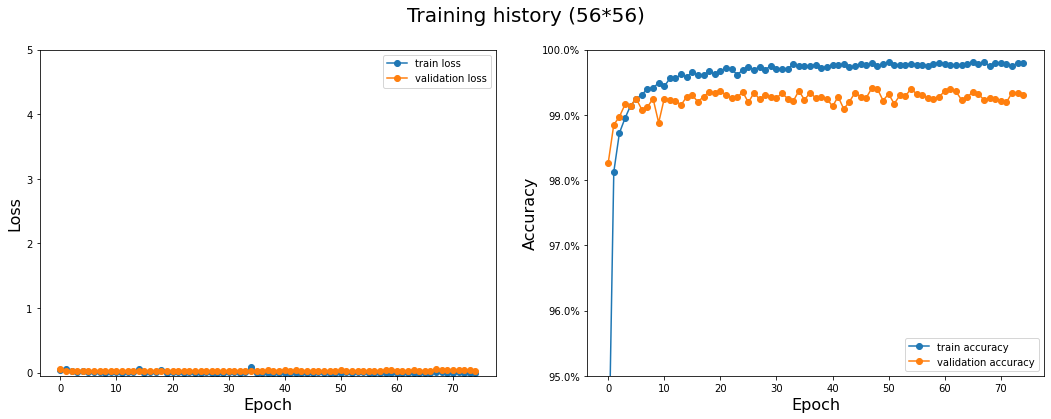

In [9]:
plot_training_history(output_56_r1,56,loss_upper = 5, acc_lower = 95, acc_higher = 100)

In [10]:
batch_size = 128
output_56_r4 = get_ann_results(resolution = 56, ratio = 4, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.8%, and Avg loss: 0.000000 

Final Validation Accuracy: 98.9%, and Avg loss: 0.059958 

Training time: 21.2 minutes


In [11]:
batch_size = 32
output_56_r10 = get_ann_results(resolution = 56, ratio = 10, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.6%, and Avg loss: 0.000000 

Final Validation Accuracy: 98.4%, and Avg loss: 0.092220 

Training time: 13.28 minutes


In [12]:
batch_size = 32
output_56_r100 = get_ann_results(resolution = 56, ratio = 100, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 96.0%, and Avg loss: 0.000002 

Final Validation Accuracy: 95.2%, and Avg loss: 0.342855 

Training time: 6.1 minutes


## 28x28

In [13]:
output_sizes = all_output_sizes(28, conv_kernel_size, conv_padding_size, conv_stride_length, mp_kernel_size, mp_padding_size, mp_stride_length)

In [14]:
batch_size = 128
output_28_r1 = get_ann_results(resolution = 28, ratio = 1, epochs =75 , verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.8%, and Avg loss: 0.000001 

Final Validation Accuracy: 99.2%, and Avg loss: 0.037507 

Training time: 20.38 minutes


In [15]:
batch_size = 128
output_28_r4 = get_ann_results(resolution = 28, ratio = 4, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.7%, and Avg loss: 0.000001 

Final Validation Accuracy: 99.0%, and Avg loss: 0.045171 

Training time: 6.71 minutes


In [16]:
batch_size = 32
output_28_r10 = get_ann_results(resolution = 28, ratio = 10, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.7%, and Avg loss: 0.000000 

Final Validation Accuracy: 98.6%, and Avg loss: 0.090961 

Training time: 5.61 minutes


In [17]:
batch_size = 32
output_28_r100 = get_ann_results(resolution = 28, ratio = 100, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 96.0%, and Avg loss: 0.000001 

Final Validation Accuracy: 95.3%, and Avg loss: 0.292728 

Training time: 3.24 minutes


## 14x14

In [18]:
conv_kernel_size = 3
conv_stride_length = 1
conv_padding_size = 1
mp_kernel_size = 3
mp_stride_length = 1
mp_padding_size = 0

In [19]:
output_sizes = all_output_sizes(14, conv_kernel_size, conv_padding_size, conv_stride_length, mp_kernel_size, mp_padding_size, mp_stride_length)

In [20]:
batch_size = 128
output_14_r1 = get_ann_results(resolution = 14, ratio = 1, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.8%, and Avg loss: 0.000003 

Final Validation Accuracy: 99.1%, and Avg loss: 0.045484 

Training time: 24.87 minutes


In [21]:
batch_size = 128
output_14_r4 = get_ann_results(resolution = 14, ratio = 4, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.7%, and Avg loss: 0.000003 

Final Validation Accuracy: 98.5%, and Avg loss: 0.068645 

Training time: 7.7 minutes


In [22]:
batch_size = 32
output_14_r10 = get_ann_results(resolution = 14, ratio = 10, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.6%, and Avg loss: 0.000001 

Final Validation Accuracy: 98.4%, and Avg loss: 0.073914 

Training time: 6.56 minutes


In [23]:
batch_size = 32
output_14_r100 = get_ann_results(resolution = 14, ratio = 100, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 95.5%, and Avg loss: 0.000648 

Final Validation Accuracy: 94.8%, and Avg loss: 0.290563 

Training time: 3.15 minutes


## 7x7

In [24]:
conv_kernel_size = 3
conv_stride_length = 1
conv_padding_size = 1
mp_kernel_size = 2
mp_stride_length = 1
mp_padding_size = 0

In [25]:
output_sizes = all_output_sizes(7, conv_kernel_size, conv_padding_size, conv_stride_length, mp_kernel_size, mp_padding_size, mp_stride_length)

In [26]:
output_sizes

[6, 6, 5, 5, 4]

In [27]:
batch_size = 128
output_7_r1 = get_ann_results(resolution = 7, ratio = 1, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.7%, and Avg loss: 0.000029 

Final Validation Accuracy: 98.2%, and Avg loss: 0.125024 

Training time: 14.11 minutes


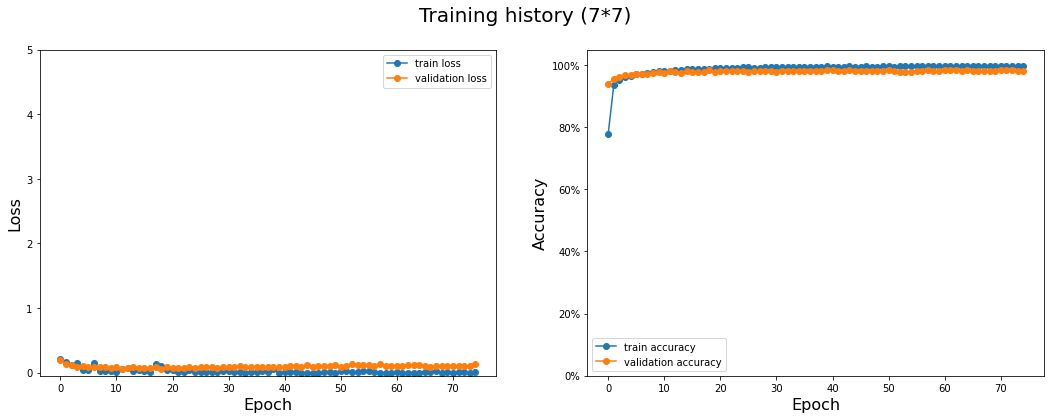

In [28]:
plot_training_history(output_7_r1,7,loss_upper = 5)

In [29]:
batch_size = 128
output_7_r4 = get_ann_results(resolution = 7, ratio = 4, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.6%, and Avg loss: 0.000047 

Final Validation Accuracy: 97.0%, and Avg loss: 0.158147 

Training time: 5.04 minutes


In [30]:
batch_size = 32
output_7_r10 = get_ann_results(resolution = 7, ratio = 10, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 99.5%, and Avg loss: 0.000000 

Final Validation Accuracy: 95.5%, and Avg loss: 0.303004 

Training time: 4.53 minutes


In [31]:
batch_size = 32
output_7_r100 = get_ann_results(resolution = 7, ratio = 100, epochs = 75, verbose = False)

Training Starting
Done!
Final Train Accuracy: 94.0%, and Avg loss: 0.001360 

Final Validation Accuracy: 88.6%, and Avg loss: 0.639344 

Training time: 2.67 minutes


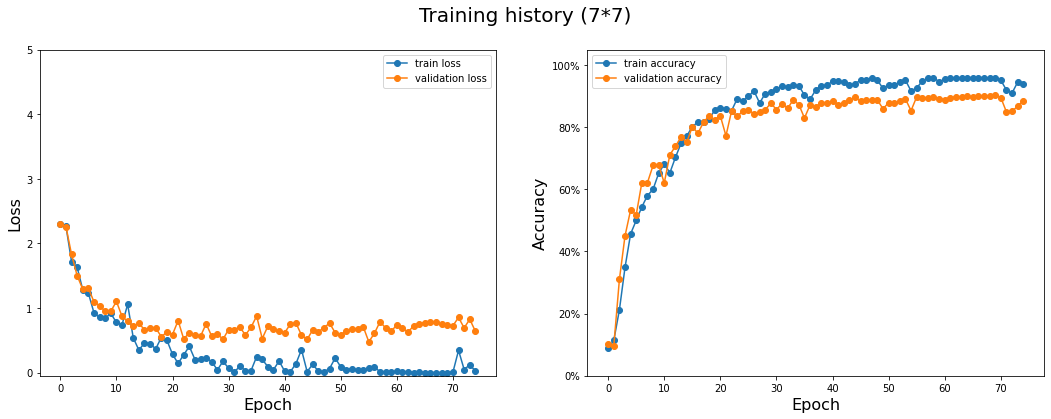

In [32]:
plot_training_history(output_7_r100,7,loss_upper = 5)

# Saving Results

In [33]:
output_res = ['output_56', 'output_28', 'output_14','output_7']
output_ratio = ['_r1','_r4','_r10','_r100']
index = ['avg_train_loss', 'train_accuracy', 'avg_valid_loss', 'valid_accuracy']

In [34]:
all_columns = []
all_models = []
for name in output_res:
    for ratio in output_ratio: 
        model_name = name + ratio
        all_models.append(model_name)
        for indice in index: 
            column_name = name + ratio + '_' + indice
            all_columns.append(column_name)

In [35]:
df = pd.DataFrame()
for entry in all_models:
    for key in index:
        string = entry + '_' + key
        
        df[string] = locals()[entry][key]

In [36]:
df.to_csv('all_cnn_training_histories_final.csv')